In [3]:
import numpy as np
from astropy.io import fits

%matplotlib notebook
import matplotlib.pyplot as plt


[[2.45884251e+06 9.87238379e+03 1.67235070e+01]
 [2.45884251e+06 9.92819629e+03 1.67783220e+01]
 [2.45884251e+06 9.91449023e+03 1.67827850e+01]
 ...
 [2.45886882e+06 9.85250781e+03 1.63107070e+01]
 [2.45886883e+06 9.87268457e+03 1.62818430e+01]
 [2.45886883e+06 9.83375195e+03 1.63120940e+01]]


<IPython.core.display.Javascript object>


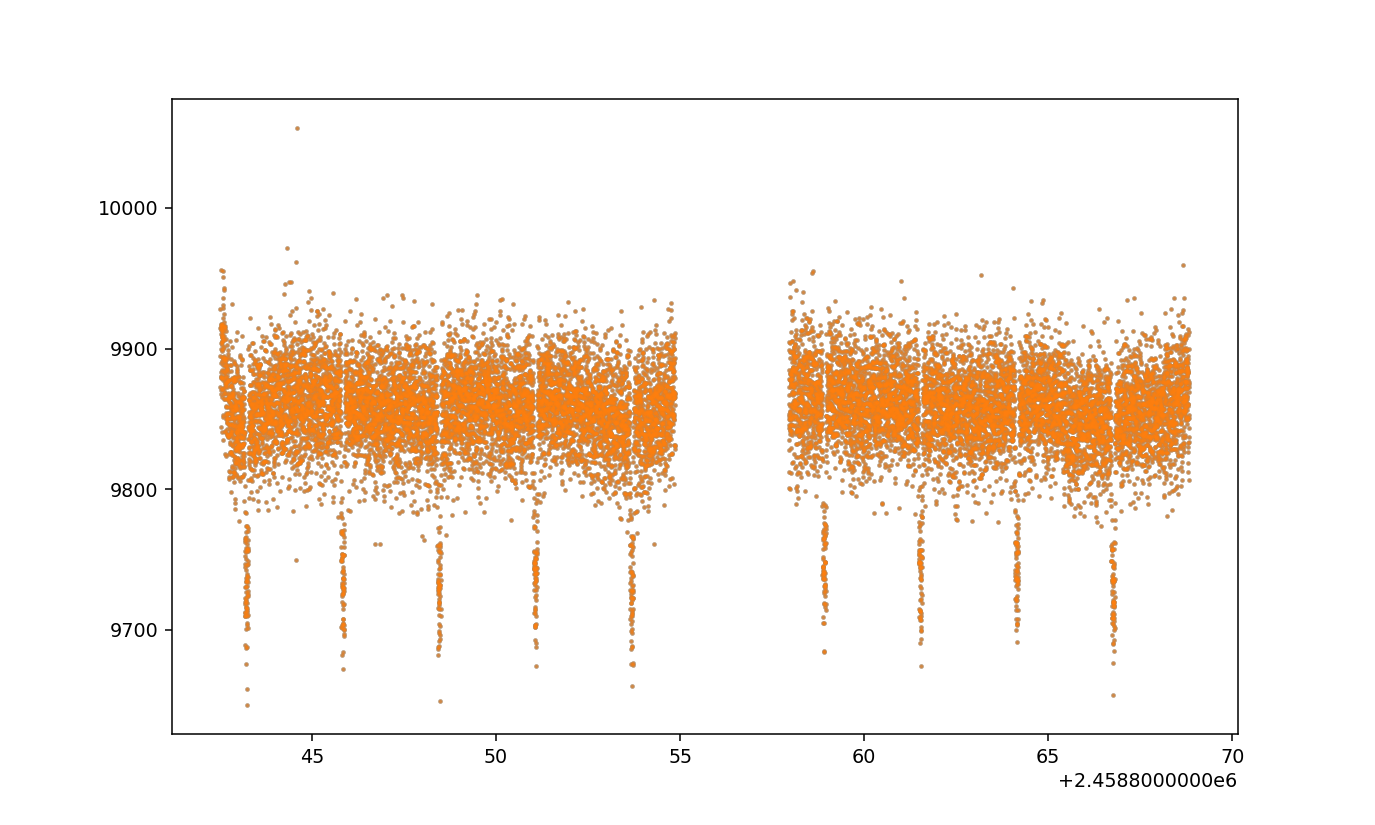

In [4]:
data = np.genfromtxt('XO2N_PDCSAPflux.dat')
# You can use "panda" as well, this is the simplest way since we are not dealing with complex databases

print(data)
time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]

plt.figure(figsize=(10,6))
plt.scatter(time, flux, s=2, alpha=0.5)
plt.show()


sel = (~np.isnan(flux))
time = data[sel,0]
flux = data[sel,1]
flux_err = data[sel,2]
plt.scatter(time, flux, c='C1', s=2, alpha=0.5)
plt.show()


<IPython.core.display.Javascript object>


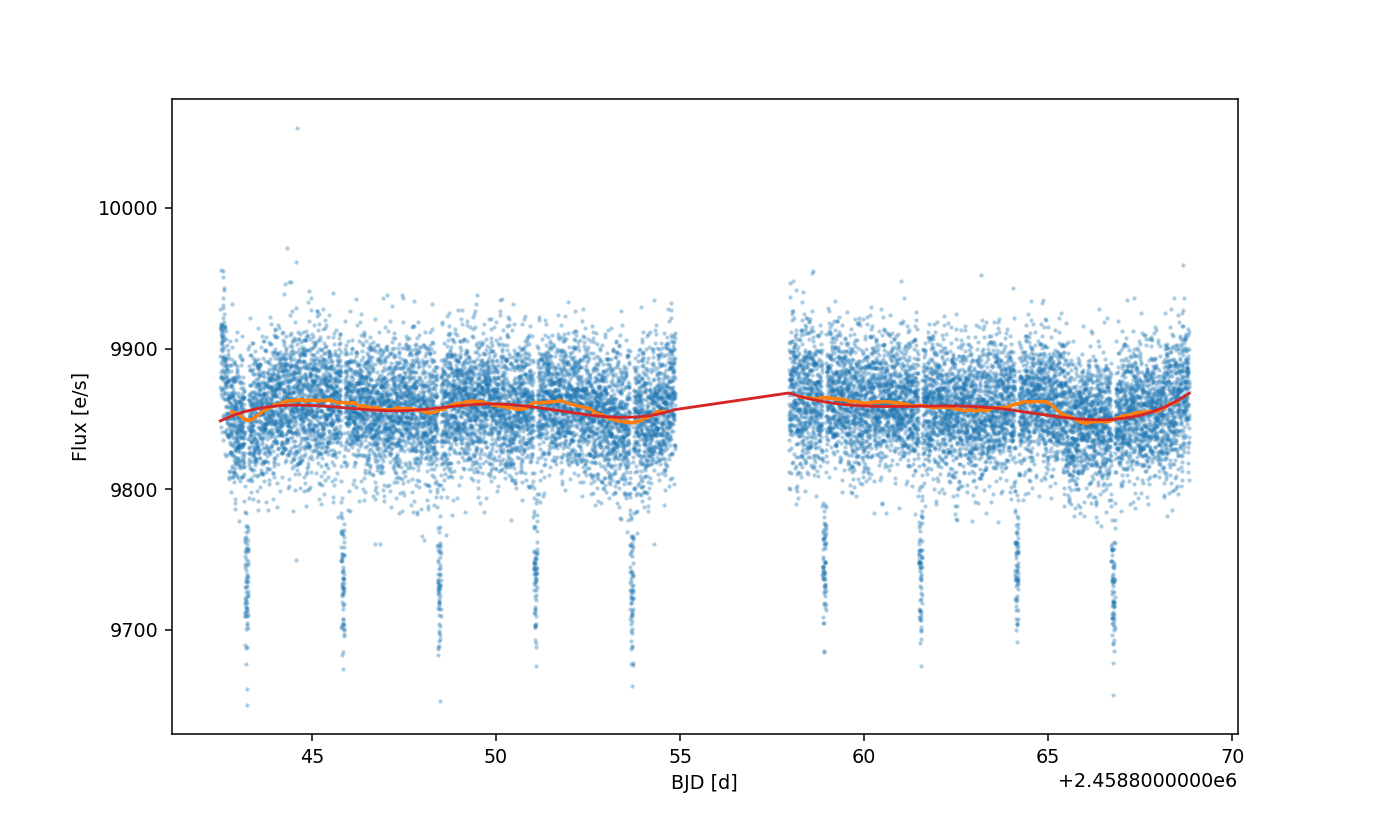

In [5]:
from wotan import flatten

flatten_bw, trend_bw = flatten(
    time[:],                 # Array of time values
    flux[:],                 # Array of flux values
    method='biweight',
    window_length=1.0,    # The length of the filter window in units of ``time``
    edge_cutoff=0.3,      # length (in units of time) to be cut off each edge.
    break_tolerance=0.5,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    cval=5.0              # Tuning parameter for the robust estimators
    )


flatten_hs, trend_hs = flatten(
    time[:],                 # Array of time values
    flux[:],                 # Array of flux values
    method='hspline',
    window_length=2.0,    # The length of the filter window in units of ``time``
    break_tolerance=0.5,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    cval=1.5              # Tuning parameter for the robust estimators
    )



plt.figure(figsize=(10,6))
plt.scatter(time, flux, s=2, alpha=0.25)

plt.plot(time, trend_bw, c='C1')
plt.plot(time, trend_hs, c='C3')

plt.xlabel('BJD [d]')
plt.ylabel('Flux [e/s]')

plt.show()

<IPython.core.display.Javascript object>


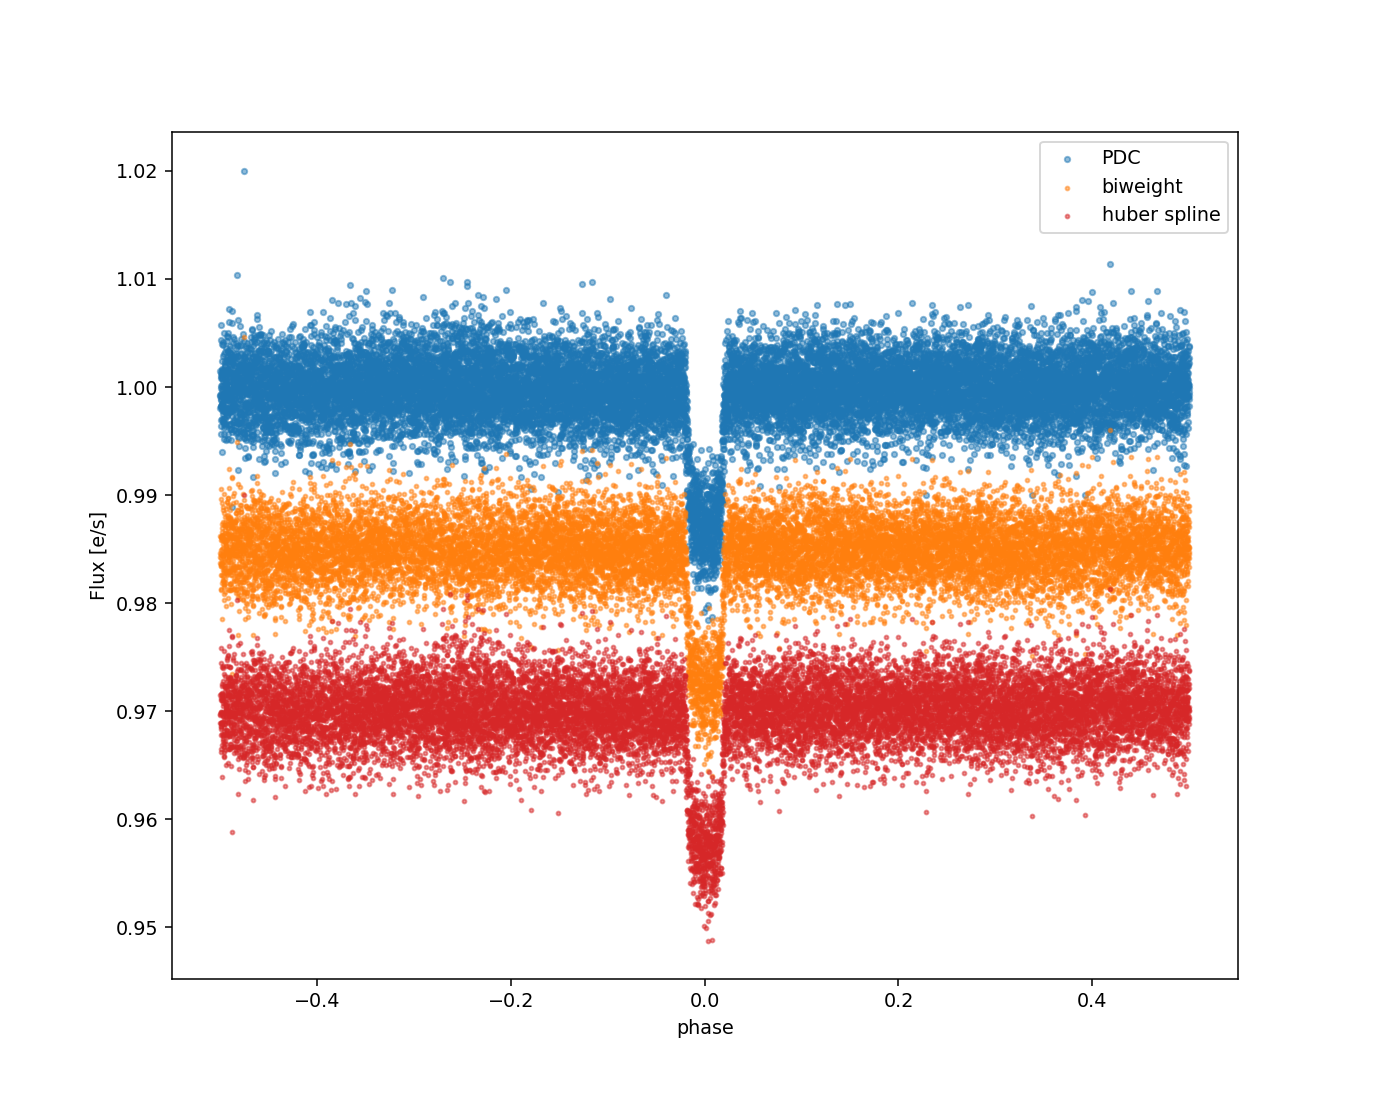

In [6]:
## Remember: lc_pipe is the photometry from standard aperture 
plt.figure(figsize=(10,8))

period = 2.61585922
time_of_transit = 2455565.546480

phase_lims = [0.15, 0.35]

phase =  ((time - time_of_transit - period/2) / period) % 1 - 0.5

# Normalization factor for PDCSAP
PDC_sel_normalization = ((np.abs(phase) > phase_lims[0]) & ((np.abs(phase) < phase_lims[1])))
PDC_norm_factor = np.nanmedian(flux[PDC_sel_normalization])

normalized_PDC = flux/PDC_norm_factor
plt.scatter(phase, normalized_PDC, s=8, c='C0', alpha=0.5, label='PDC')



#sel_normalization = ((np.abs(phase) > phase_lims[0]) & ((np.abs(phase) < phase_lims[1]))) 
#norm_factor = np.median(flatten_lc[sel_normalization])
plt.scatter(phase, flatten_bw - 0.015, c='C1', s=4, label='biweight', alpha=0.5)
plt.scatter(phase, flatten_hs - 0.030, c='C3', s=4, label='huber spline', alpha=0.5)


plt.xlabel('phase')
plt.ylabel('Flux [e/s]')

plt.legend()
plt.show()

In [7]:
sel = (np.abs(phase) > 0.05) & (np.abs(phase) < 0.10) & (~np.isnan(flatten_bw)) & (~np.isnan(flatten_hs))
print('PDCSAP STD:', np.std(normalized_PDC[sel]))
print('biweight STD:', np.std(flatten_bw[sel]))
print('huber STD:', np.std(flatten_hs[sel]))

PDCSAP STD: 0.002599890562669335
biweight STD: 0.002531732124577381
huber STD: 0.0025536721845314907


In [9]:
# Save to file the FLATTENED light curve

# open a file in writing (w) mode
fileout = open('XO2N_PDCSAP_flattened_biweight.dat', 'w') 

# flatten_lc is equal to flux / trend_lc
# you have to do the same for the error associated to the flux, since it has not ben treated by wotan 
for t, f, e in zip(time, flatten_bw, flux_err/trend_bw):
    if np.isnan(f): continue
    # TRICK
    fileout.write('{0:17.7f} {1:14f} {2:14f}\n'.format(t, f, e))

fileout.close()

# etc etc